In [40]:
# source proxypicker-env/bin/activate
# 
# cd /Users/jamaman/Documents/GitHub/ProxyPicker/images
# 
# python3 -m http.server
# 
# image_url = "http://localhost:8000/1.jpg"



In [111]:
import os, getpass
import operator
import base64
from pydoc import describe

import httpx
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send
from IPython.display import Image
from langgraph.graph import END, StateGraph, START, MessagesState, add_messages
from langchain_core.messages import AnyMessage
from langchain_openai import ChatOpenAI
from typing import List
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [112]:
proxy_picker_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1, base_url="https://reverse.onechats.top/v1")

In [113]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "proxy_picker"

In [114]:
object_fetching_prompt = """You are an object fetcher. Please carefully inspect and list all visible physical objects in the image(s) of surrounding objects regarding their name and position only, ensuring that no object is overlooked."""
attribute_extraction_prompt = """You are an attribute extracter. Please describe physical properties of the {target_object} with its position in the given picture: {object_position} , in terms of its inertia, interactivity, outline, texture, and hardness"""
interaction_parsing_prompt = """You are an interaction parser. Please comprehend the haptic feedback a user should perceive while interacting with the virtual object in terms of interacted virtual object, contacted part, interaction, and external forces based on the given task: {given_task}, and the given picture of the interacted virtual object"""
interaction_exploring_prompt = """You are an interaction explorer. Please come up with the most suitable and plausible way of utilizing {target_object} in the given picture ({object_position}) as a haptic proxy of {virtual_object} in virtual reality. When thinking about the interaction possibility, consider the following information carefully, and comprehensively explain how users interact with {target_object} in reality to trigger expected haptic feedbacks.

The interaction between users and {virtual_object} in VR: {given_task}

Here is the parsed detail of the interaction in VR: {parsed_interaction}

Here is the extracted attribute of {target_object}: {extracted_attribute}"""

candidate_evaluation_prompt = """You are a haptic proxy evaluator. Your job is to evaluate the suitability of physical objects' interaction possibilities as a haptic proxy to perform the given task in VR. 

The given task in VR is: {given_task}

{parsed_interaction}

Please evaluate the interaction possibilities of physical objects regarding criteria of inertia, interactivity, outline, texture, and hardness compared to ideal haptic feedbacks. 

Inertia: The potential matches the virtual object's weight or inertia.
Interactivity: The potential facilitates the specific types of interactions the user will perform in the virtual environment, such as pressing, rotating, sliding, extending, or any other purposeful manipulation.
Outline: The physical shape and size of contact parts closely resemble the part of the virtual that users would contact and/or interact with.
Texture: The surface texture of contact parts mimics the part of the virtual object that users would contact and/or interact with.
Hardness: The material stiffness of contact and/or flexible parts corresponds to the part of the virtual object that users would contact and/or interact with.

Rate each criterion for the physical object's interaction possibility out of 5 points. Then calculate each physical object's weighted average with respective criteria weights.

Criteria weights: {criteria_weights}

Interaction possibilities to be evaluated: \n\n {interaction_possibilities}

Please return the top 3 candidates with the rating result of each criterion and total score. Sort them in descending order of total score."""

In [115]:
physical_url = "http://localhost:8000/p1.jpg"
image_data = base64.b64encode(httpx.get(physical_url).content).decode("utf-8")

prefab_url = "http://localhost:8000/f1.jpg"
prefab_data = base64.b64encode(httpx.get(physical_url).content).decode("utf-8")

In [116]:
class Proxy(BaseModel):
    name: str = Field(description="The name of the physical object")
    position: str = Field(description="The relative positions of the physical object in the given picture")
    
    inertia: str = Field(None, description="The physical object's weight or inertia")
    interactivity: str = Field(None, description="Types of interactions a user could perform with the physical object, such as pressing, rotating, sliding, extending, or any other purposeful manipulation")
    outline: str = Field(None, description="The shape and size of the physical object as well as its subparts")
    texture: str = Field(None, description="The surface texture of the physical object as well as its subparts")
    hardness: str = Field(None, description="The material stiffness of the physical object as well as its subparts")
    
    interaction_possibility: str = Field(None, description="Comprehensive explanation of the most suitable way to utilize this physical object as a haptic proxy for the virtual object")
    
    @property
    def attribute(self) -> str:
        return f"Haptic Proxy: {self.name}\nPosition: {self.position}\nInertia: {self.inertia}\nInteractivity: {self.interactivity}\nOutline: {self.outline}\nTexture: {self.texture}\nHardness: {self.hardness}"
    
    @property
    def evaluation(self) -> str:
        return f"Physical Object: {self.name}\nPosition in Given Picture: {self.position}\nInteraction Possibility: {self.interaction_possibility}"
    
class ProxyCandidates(BaseModel):
    proxies: List[Proxy] = Field(description="Comprehensive list of physical objects in the given picture")

class TopCandidate(BaseModel):
    name: str = Field(description="The name of the physical object")
    position: str = Field(description="The relative positions of the physical object in the given picture")   
    interaction_possibility: str = Field(description="Comprehensive explanation of the most suitable way to utilize this physical object as a haptic proxy for the virtual object")
    
    rating_inertia: int = Field(None, description="The rating of inertia")
    rating_interactivity: int = Field(None, description="The rating of interactivity")
    rating_outline: int = Field(None, description="The rating of outline")
    rating_texture: int = Field(None, description="The rating of texture")
    rating_hardness: int = Field(None, description="The rating of hardness")
    total_score: float = Field(None, description="The weighted average of all five ratings")
    
class TopCandidates(BaseModel):
    candidates: List[TopCandidate] = Field(description="List of top 3 candidates with descending order of their total scores")

class Prefab(BaseModel):
    prefab_name: str = Field(description="Identify what virtual object the user will grasp and/or interact with to perform the given task")
    contacted_part: str = Field(description="Identify which part(s) of the virtual object will be mainly contacted by the user during the interaction")
    involved_interaction: str = Field(description="Determine how the virtual object will be interacted by the user")
    external_force: str = Field(description="Consider what types of external forces the user might encounter during the interaction")
    
    @property
    def review(self) -> str:
        return f"The given task is parsed as follow in terms of what haptic feedback a user should perceive while interacting with the virtual object in virtual reality:\nVirtual Object: {self.prefab_name}\nForm: {self.contacted_part}\nInteraction: {self.involved_interaction}\nExternal Forces: {self.external_force}"
    
class OverallState(MessagesState):
    given_task: str
    
    involvement: str
    transportability: str
    reconfiguration: str
    
    score_inertia: int
    score_interaction: int
    score_outline: int
    score_texture: int
    score_hardness: int

    proxies: List[Proxy]
    proxy_candidates_complete: Annotated[list, operator.add]
    prefab: Prefab
    weight_dict: dict
    top_candidates: List[TopCandidate]
    
class InspectState(TypedDict):
    target_object: Proxy
    given_task: str
    prefab: Prefab
    proxy_candidates_complete: List[Proxy]
    
class InspectOutputState(TypedDict):
    proxy_candidates_complete: List[Proxy]


In [117]:
def calculate_weighted_average(rating_inertia: int, rating_interactivity: int, rating_outline: int, rating_texture: int, rating_hardness: int, weight_inertia: float, weight_interactivity: float, weight_outline: float, weight_texture: float, weight_hardness: float):
    """Calculate weighted average.
    
    Args:
        rating_inertia: result of inertia rating
        rating_interactivity: result of interactivity rating
        rating_outline: result of outline rating
        rating_texture: result of texture rating
        rating_hardness: result of hardness rating
        weight_inertia: weight of inertia
        weight_interactivity: weight of interactivity
        weight_outline: weight of outline
        weight_texture: weight of texture
        weight_hardness: weight of hardness
    """
    weighted_average =  rating_inertia * weight_inertia + rating_interactivity * weight_interactivity + rating_outline * weight_outline + rating_texture * weight_texture + weight_hardness * weight_hardness
    return weighted_average

tools = [calculate_weighted_average]
proxy_picker_llm_tools = proxy_picker_llm.bind_tools(tools)

In [118]:
def weight_calculator (state: OverallState):
    attributes = ["inertia", "interactivity", "outline", "texture", "hardness"]
    ratings = [state["score_inertia"], state["score_interaction"], state["score_outline"], state["score_texture"], state["score_hardness"]]
    weights = [rating / sum(ratings) for rating in ratings]
    
    weighted_attributes = dict(zip(attributes, weights))
    return {"weight_dict": weighted_attributes}

def object_fetcher (state: OverallState):
    prompt_system = SystemMessage(content=[object_fetching_prompt])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(ProxyCandidates).invoke(messages)
    return {"proxies": response.proxies} #messages should also be a list : "messages": [response]    
    
def interaction_parser (state: OverallState):
    prompt_system = SystemMessage(content=[interaction_parsing_prompt.format(given_task=state["given_task"])])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image of interacted virtual object:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(Prefab).invoke(messages)
    return {"prefab": response}

def candidate_evaluator (state: OverallState):
    possibilities = "\n\n".join(p.evaluation for p in state["proxy_candidates_complete"])
    prompt_system = SystemMessage(content=[candidate_evaluation_prompt.format(given_task=state["given_task"], parsed_interaction=state["prefab"].review, criteria_weights=state["weight_dict"], interaction_possibilities=possibilities)])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
        {
            "type": "text",
            "text": "image of interacted virtual object:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(TopCandidates).invoke(messages)
    return {"top_candidates": response.candidates}
    

In [119]:
def continue_to_attrbute(state: OverallState):
    return [Send("proxy_inspector", {"target_object": t, "given_task": state["given_task"], "prefab": state["prefab"]}) for t in state["proxies"]]

def attribute_extracter (state: InspectState):
    prompt_system = SystemMessage(content=[attribute_extraction_prompt.format(target_object=state["target_object"].name, object_position=state["target_object"].position)])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm.with_structured_output(Proxy).invoke(messages)
    return {"target_object": response}

def interaction_explorer(state: InspectState):
    prompt_system = SystemMessage(content=[interaction_exploring_prompt.format(target_object=state["target_object"].name, object_position=state["target_object"].position,  given_task=state["given_task"], virtual_object=state["prefab"].prefab_name, parsed_interaction=state["prefab"].review, extracted_attribute=state["target_object"].attribute)])
    prompt_human = HumanMessage(content=[
        {
            "type": "text",
            "text": "image(s) of surrounding objects:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
        {
            "type": "text",
            "text": "image of interacted virtual object:",
        },
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{prefab_data}"},
        }
    ])
    messages = [prompt_system, prompt_human]
    response = proxy_picker_llm_tools.with_structured_output(Proxy).invoke(messages)
    return {"proxy_candidates_complete": [response]}

/var/folders/dm/mwc26gqj5kvbzk2nffzh__5m0000gn/T/ipykernel_20613/244596100.py:1: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  builder = StateGraph(input=InspectState, output=InspectOutputState)


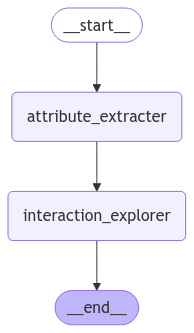

In [120]:
builder = StateGraph(input=InspectState, output=InspectOutputState)
builder.add_node("attribute_extracter", attribute_extracter)
builder.add_node("interaction_explorer", interaction_explorer)

builder.add_edge(START, "attribute_extracter")
builder.add_edge("attribute_extracter", "interaction_explorer")
builder.add_edge("interaction_explorer", END)

proxy_inspector = builder.compile()
Image(proxy_inspector.get_graph().draw_mermaid_png())

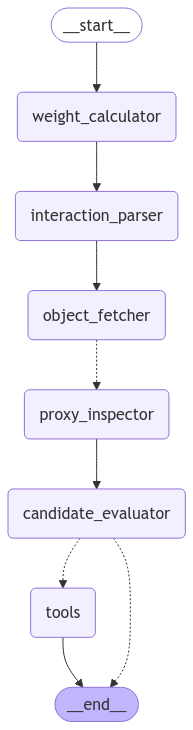

In [123]:
graph = StateGraph(OverallState)
graph.add_node("weight_calculator", weight_calculator)
graph.add_node("interaction_parser", interaction_parser)
graph.add_node("object_fetcher", object_fetcher)
graph.add_node("proxy_inspector", proxy_inspector)
graph.add_node("candidate_evaluator", candidate_evaluator)
graph.add_node("tools", ToolNode(tools))


graph.add_edge(START, "weight_calculator")
graph.add_edge("weight_calculator", "interaction_parser")
graph.add_edge("interaction_parser", "object_fetcher")
graph.add_conditional_edges("object_fetcher", continue_to_attrbute, ["proxy_inspector"])
graph.add_edge("proxy_inspector", "candidate_evaluator")
graph.add_conditional_edges("candidate_evaluator", tools_condition,)
graph.add_edge("tools", END)

proxy_picker = graph.compile()
Image(proxy_picker.get_graph().draw_mermaid_png())

In [124]:
for s in proxy_picker.stream({"given_task": "scrutinise using binoculars", "involvement": "grasp", "transportability": "stationary", "reconfiguration": "rigid", "score_inertia": 3, "score_interaction": 0, "score_outline": 5, "score_texture": 3, "score_hardness": 2}):
    print(s)

{'weight_calculator': {'weight_dict': {'inertia': 0.23076923076923078, 'interactivity': 0.0, 'outline': 0.38461538461538464, 'texture': 0.23076923076923078, 'hardness': 0.15384615384615385}}}
{'interaction_parser': {'prefab': Prefab(prefab_name='binoculars', contacted_part='the binoculars', involved_interaction='scrutinizing objects through the binoculars', external_force='gravity and slight resistance when focusing')}}
{'object_fetcher': {'proxies': [Proxy(name='Headphones', position='Top left', inertia='Lightweight', interactivity='Adjusting volume, pressing buttons', outline='Over-ear design with a padded headband', texture='Smooth leather-like surface', hardness='Soft', interaction_possibility='Wear on head for audio experience'), Proxy(name='Fitness Tracker', position='Top center', inertia='Lightweight', interactivity='Tapping on screen, pressing buttons', outline='Wristband style', texture='Rubberized surface', hardness='Soft', interaction_possibility='Wear on wrist for fitness t

ValueError: No messages found in input state to tool_edge: {'top_candidates': [TopCandidate(name='Headphones', position='Top left', interaction_possibility='The headphones can be used as a haptic proxy for binoculars in virtual reality by simulating the experience of focusing and adjusting the view. Users can tilt or rotate the headphones slightly to mimic the action of adjusting binoculars, while the soft padding provides comfort during prolonged use. The lightweight nature allows for easy manipulation, and the volume control can be used to simulate the adjustment of focus, with increased volume representing a closer view and decreased volume representing a distant view. Additionally, pressing buttons on the headphones can trigger haptic feedback that corresponds to the sensation of focusing on distant objects, enhancing the immersive experience.', rating_inertia=4, rating_interactivity=0, rating_outline=4, rating_texture=4, rating_hardness=3, total_score=3.615384615384615), TopCandidate(name='Game Controller', position='Middle center', interaction_possibility='The Game Controller can be utilized as a haptic proxy for binoculars in a virtual reality environment by simulating the act of focusing and adjusting the binoculars. Users can press the triggers to simulate the action of adjusting the focus, while the joysticks can be used to pan and tilt the view, mimicking the movement of binoculars. Haptic feedback can be triggered when the user presses the buttons, providing a sensation that mimics the slight resistance felt when focusing on distant objects. Additionally, the controller can vibrate lightly to simulate the feeling of gravity as the user holds the binoculars steady, enhancing the immersive experience.', rating_inertia=4, rating_interactivity=0, rating_outline=4, rating_texture=4, rating_hardness=4, total_score=3.923076923076923), TopCandidate(name='Mug', position='Top right', interaction_possibility='The Mug can be utilized as a haptic proxy for binoculars in virtual reality by allowing users to lift it to their eyes, mimicking the action of holding binoculars. Users can tilt the Mug to adjust their view, simulating the focusing mechanism of binoculars. The smooth metallic surface provides a realistic feel, while the medium hardness gives a satisfying grip. When users lift and tilt the Mug, they can experience haptic feedback that simulates the resistance and weight of binoculars, enhancing immersion in the virtual environment.', rating_inertia=4, rating_interactivity=0, rating_outline=4, rating_texture=4, rating_hardness=4, total_score=3.923076923076923)], 'messages': [], 'given_task': 'scrutinise using binoculars', 'involvement': 'grasp', 'transportability': 'stationary', 'reconfiguration': 'rigid', 'score_inertia': 3, 'score_interaction': 0, 'score_outline': 5, 'score_texture': 3, 'score_hardness': 2, 'proxies': [Proxy(name='Headphones', position='Top left', inertia='Lightweight', interactivity='Adjusting volume, pressing buttons', outline='Over-ear design with a padded headband', texture='Smooth leather-like surface', hardness='Soft', interaction_possibility='Wear on head for audio experience'), Proxy(name='Fitness Tracker', position='Top center', inertia='Lightweight', interactivity='Tapping on screen, pressing buttons', outline='Wristband style', texture='Rubberized surface', hardness='Soft', interaction_possibility='Wear on wrist for fitness tracking'), Proxy(name='Mouse', position='Top center right', inertia='Moderate', interactivity='Clicking, scrolling, moving', outline='Ergonomic shape', texture='Smooth surface', hardness='Hard plastic', interaction_possibility='Use for computer navigation'), Proxy(name='Charging Cable', position='Top center', inertia='Very light', interactivity='Bending, twisting', outline='Long, thin cable', texture='Flexible rubber', hardness='Soft', interaction_possibility='Connect devices for charging'), Proxy(name='Mug', position='Top right', inertia='Moderate', interactivity='Lifting, tilting', outline='Cylindrical with a handle', texture='Smooth glossy surface', hardness='Hard ceramic', interaction_possibility='Hold for drinking'), Proxy(name='Face Mask', position='Middle left', inertia='Very light', interactivity='Adjusting fit, folding', outline='Rectangular fabric', texture='Fabric surface', hardness='Soft', interaction_possibility='Wear for protection'), Proxy(name='Remote Control', position='Middle center', inertia='Lightweight', interactivity='Pressing buttons, scrolling', outline='Rectangular with buttons', texture='Smooth surface', hardness='Hard plastic', interaction_possibility='Control devices like TV'), Proxy(name='Guitar Pick', position='Middle right', inertia='Very light', interactivity='Holding, strumming', outline='Triangular shape', texture='Smooth surface', hardness='Hard plastic', interaction_possibility='Use for playing guitar'), Proxy(name='Duck Lamp', position='Middle right', inertia='Lightweight', interactivity='Turning on/off, adjusting position', outline='Duck shape with a base', texture='Smooth surface', hardness='Soft plastic', interaction_possibility='Use as a lamp'), Proxy(name='Sticky Note', position='Middle left', inertia='Very light', interactivity='Peeling off, sticking', outline='Square', texture='Paper surface', hardness='Soft', interaction_possibility='Write reminders'), Proxy(name='Game Controller', position='Middle center', inertia='Moderate', interactivity='Pressing buttons, moving joysticks', outline='Ergonomic design with buttons', texture='Smooth surface', hardness='Hard plastic', interaction_possibility='Use for gaming'), Proxy(name='Scissors', position='Middle right', inertia='Moderate', interactivity='Opening/closing blades', outline='Two blades with handles', texture='Smooth metal surface', hardness='Hard metal and plastic', interaction_possibility='Cutting materials'), Proxy(name='Pen', position='Bottom left', inertia='Very light', interactivity='Pressing, twisting', outline='Cylindrical', texture='Smooth surface', hardness='Hard plastic', interaction_possibility='Writing'), Proxy(name='Crumbled Paper', position='Bottom center', inertia='Very light', interactivity='Holding, tossing', outline='Irregular shape', texture='Paper surface', hardness='Soft', interaction_possibility='Dispose of or recycle'), Proxy(name='Black Folder', position='Bottom right', inertia='Moderate', interactivity='Opening, closing', outline='Rectangular', texture='Smooth surface', hardness='Hard', interaction_possibility='Store documents')], 'proxy_candidates_complete': [Proxy(name='Headphones', position='Top left', inertia='lightweight', interactivity='Users can adjust the volume, press buttons for playback control, and connect/disconnect from devices, simulating the adjustments made when using binoculars.', outline='Curved headband with two circular ear cups designed to fit comfortably over the ears.', texture='Soft, padded ear cups with a smooth or slightly textured headband.', hardness='medium', interaction_possibility='The headphones can be used as a haptic proxy for binoculars in virtual reality by simulating the experience of focusing and adjusting the view. Users can tilt or rotate the headphones slightly to mimic the action of adjusting binoculars, while the soft padding provides comfort during prolonged use. The lightweight nature allows for easy manipulation, and the volume control can be used to simulate the adjustment of focus, with increased volume representing a closer view and decreased volume representing a distant view. Additionally, pressing buttons on the headphones can trigger haptic feedback that corresponds to the sensation of focusing on distant objects, enhancing the immersive experience.'), Proxy(name='Fitness Tracker', position='Top center', inertia='lightweight', interactivity='Users can press buttons to zoom, swipe to navigate through views, and rotate the device to adjust focus, simulating the experience of using binoculars.', outline='rectangular shape with rounded edges', texture='smooth with a slight matte finish', hardness='soft', interaction_possibility='The fitness tracker can be utilized as a haptic proxy for binoculars in a virtual reality environment by simulating the act of focusing and adjusting the binoculars. Users can press buttons on the fitness tracker to zoom in or out, mimicking the adjustment of binoculars. The slight resistance felt when pressing can simulate the tactile feedback of focusing the binoculars. Additionally, swiping on the fitness tracker can allow users to navigate through different views or objects they are scrutinizing, providing a sense of exploration. The lightweight nature of the tracker makes it easy to handle, enhancing the immersive experience of using binoculars in VR.'), Proxy(name='Mouse', position='Top center right', inertia='lightweight', interactivity='Clicking to zoom in/out, scrolling to adjust focus, and moving across a surface to navigate the virtual environment.', outline='Compact, ergonomic shape suitable for comfortable handling.', texture='Smooth plastic surface with a slight grip for better handling.', hardness='moderate', interaction_possibility='The mouse can be used as a haptic proxy for binoculars in a virtual reality environment by allowing users to click and scroll to zoom in and out on objects they are scrutinizing. The smooth surface of the mouse enables easy movement across a surface, mimicking the action of adjusting binoculars. Users can also experience slight resistance when focusing, simulating the tactile feedback of adjusting the focus on real binoculars. Additionally, the ergonomic shape of the mouse provides comfort during extended use, enhancing the overall experience.'), Proxy(name='Charging Cable', position='Top center', inertia='lightweight', interactivity="Users can plug in or unplug the cable, coil or uncoil it, and simulate focusing by pulling the ends apart or bringing them closer together. They can also rotate the cable slightly to mimic adjusting the binoculars' focus.", outline='thin, elongated, flexible', texture='smooth, possibly rubberized or plastic', hardness='soft', interaction_possibility='The Charging Cable can be used as a haptic proxy for binoculars in a virtual reality environment by allowing users to manipulate it in a way that simulates the experience of using binoculars. Users can hold the Charging Cable in both hands, mimicking the grip of binoculars. As they pull the cable apart (uncoiling it), they can feel a slight resistance, simulating the action of focusing the binoculars. When they bring the ends closer together, they can experience a sense of gravity as the cable naturally falls back into place, enhancing the realism of the interaction. Additionally, the smooth texture of the cable can provide tactile feedback that mimics the feel of binoculars, while the soft hardness allows for comfortable handling during prolonged use.'), Proxy(name='Mug', position='Top right', inertia='lightweight', interactivity='lifting, tilting, placing', outline='cylindrical with a handle', texture='smooth metallic surface', hardness='medium', interaction_possibility='The Mug can be utilized as a haptic proxy for binoculars in virtual reality by allowing users to lift it to their eyes, mimicking the action of holding binoculars. Users can tilt the Mug to adjust their view, simulating the focusing mechanism of binoculars. The smooth metallic surface provides a realistic feel, while the medium hardness gives a satisfying grip. When users lift and tilt the Mug, they can experience haptic feedback that simulates the resistance and weight of binoculars, enhancing immersion in the virtual environment.'), Proxy(name='Face Mask', position='Middle left', inertia='lightweight', interactivity='Users can pull, stretch, or fold the face mask to simulate the focusing mechanism of binoculars. They can also press or squeeze the mask to trigger haptic feedback that corresponds to the action of adjusting the binoculars.', outline='rectangular with rounded edges', texture='smooth fabric surface', hardness='soft', interaction_possibility='The face mask can be utilized as a haptic proxy for binoculars in virtual reality by allowing users to pull and stretch the mask to simulate the action of adjusting the binoculars for focus. When users pull the mask, they can feel a slight resistance, mimicking the physical effort required to focus binoculars. The smooth texture of the mask can enhance the tactile experience, providing a comfortable grip as users interact with the virtual environment. Additionally, the soft material can provide subtle vibrations or feedback through the VR system to simulate the sensation of weight and gravity when scrutinizing distant objects.'), Proxy(name='Remote Control', position='Middle center', inertia='lightweight', interactivity='pressing buttons, scrolling, selecting options, simulating focus adjustments', outline='rectangular with rounded edges', texture='smooth plastic surface with tactile buttons', hardness='medium', interaction_possibility='The Remote Control can be used as a haptic proxy for binoculars in virtual reality by allowing users to simulate the experience of focusing and adjusting the binoculars. Users can press buttons to zoom in and out, mimicking the action of adjusting the focus on real binoculars. The directional pad can be used to navigate through different views or objects in the virtual environment, providing a sense of exploration. Haptic feedback can be triggered when users press buttons, simulating the resistance felt when adjusting the focus of binoculars. Additionally, slight vibrations can be used to represent the weight of the binoculars and the effect of gravity when users are scrutinizing objects in the virtual space.'), Proxy(name='Guitar Pick', position='Middle right', inertia='lightweight', interactivity='Pressing, sliding, and rotating for different adjustments and focus techniques.', outline='Triangular shape with rounded edges, typically about 1-2 mm thick.', texture='Smooth surface with a slight grip for better handling.', hardness='medium', interaction_possibility='The Guitar Pick can be utilized as a haptic proxy for binoculars in a virtual reality environment by allowing users to press, slide, and rotate the pick to simulate the actions of adjusting focus and zooming in on distant objects. When users press the pick, they can feel a slight resistance that mimics the tactile feedback of adjusting the binoculars. Sliding the pick can simulate the action of panning or scanning the environment, while rotating it can represent fine adjustments in focus. The lightweight nature of the pick ensures that users can easily manipulate it without fatigue, enhancing the immersive experience of scrutinizing objects in VR.'), Proxy(name='Duck Lamp', position='Middle right', inertia='lightweight', interactivity='pressing to turn on/off, rotating for brightness adjustment', outline='rounded body with a duck-like shape, small beak, and two legs', texture='smooth plastic surface', hardness='soft', interaction_possibility='The Duck Lamp can be utilized as a haptic proxy for binoculars in a virtual reality environment by allowing users to physically manipulate the lamp to simulate the experience of using binoculars. Users can hold the Duck Lamp in one hand, pressing it to turn it on or off, which corresponds to activating the binoculars in VR. The lightweight nature of the Duck Lamp allows for easy handling, mimicking the feel of holding binoculars. Users can also rotate the lamp to adjust brightness, simulating the action of focusing the binoculars. As they scrutinize virtual objects, the haptic feedback can be programmed to provide slight vibrations or resistance when focusing, enhancing the immersive experience.'), Proxy(name='Sticky Note', position='Middle left', inertia='lightweight', interactivity='Users can press, write on, and remove the Sticky Note, simulating the adjustments made when using binoculars. Pressing down can represent focusing, while writing can symbolize taking notes on what they observe through the binoculars.', outline='square shape, approximately 3 inches by 3 inches', texture='smooth surface with a slightly tacky back', hardness='soft', interaction_possibility="The Sticky Note can be used as a haptic proxy for binoculars in a virtual reality environment by allowing users to press and manipulate it to simulate the action of focusing and adjusting the binoculars. When users press down on the Sticky Note, they can feel a slight resistance, mimicking the tactile feedback of adjusting the focus on binoculars. Additionally, writing on the Sticky Note can represent taking notes or observations while using the binoculars, enhancing the immersive experience. The lightweight nature of the Sticky Note allows for easy handling, making it a suitable proxy for the binoculars' form and function."), Proxy(name='Game Controller', position='Middle center', inertia='lightweight', interactivity='pressing buttons, moving joysticks, triggering actions', outline='ergonomic shape with rounded edges and distinct button layout', texture='smooth plastic surface with textured grips', hardness='medium', interaction_possibility='The Game Controller can be utilized as a haptic proxy for binoculars in a virtual reality environment by simulating the act of focusing and adjusting the binoculars. Users can press the triggers to simulate the action of adjusting the focus, while the joysticks can be used to pan and tilt the view, mimicking the movement of binoculars. Haptic feedback can be triggered when the user presses the buttons, providing a sensation that mimics the slight resistance felt when focusing on distant objects. Additionally, the controller can vibrate lightly to simulate the feeling of gravity as the user holds the binoculars steady, enhancing the immersive experience.'), Proxy(name='Scissors', position='Middle right', inertia='lightweight', interactivity='Users can press the handles together to simulate focusing, and rotate the scissors to adjust the angle, similar to how they would adjust binoculars.', outline='Symmetrical shape with two blades converging at a pivot point, and two handles on either side. The blades are elongated and taper to a sharp point.', texture='Smooth handles with polished blades.', hardness='medium', interaction_possibility='Users can hold the scissors in one hand, mimicking the action of holding binoculars. By pressing the handles together, they can simulate the action of focusing the binoculars, feeling a slight resistance that mimics the adjustment of focus. The lightweight nature of the scissors allows for easy manipulation, and users can rotate them to simulate adjusting the angle of view, providing a tactile feedback that enhances the virtual experience.'), Proxy(name='Pen', position='Bottom left', inertia='lightweight', interactivity='pressing, sliding', outline='cylindrical shape, approximately 14 cm long', texture='smooth surface', hardness='medium', interaction_possibility="The pen can be used as a haptic proxy for binoculars in virtual reality by allowing users to simulate the act of holding and adjusting binoculars. Users can press the pen to activate the binoculars in the VR environment, mimicking the action of focusing. Sliding the pen can simulate the adjustment of the binoculars' focus, providing tactile feedback that corresponds to the resistance felt when adjusting real binoculars. The smooth surface of the pen allows for easy manipulation, while its cylindrical shape fits comfortably in the hand, enhancing the immersive experience."), Proxy(name='Crumpled Paper', position='Bottom center', inertia='lightweight', interactivity='Crumpling, flattening, tossing, tearing', outline='irregular, crumpled shape', texture='wrinkled and uneven surface', hardness='soft', interaction_possibility="Users can crumple the paper to simulate the act of adjusting the focus on binoculars, providing a tactile feedback that mimics the resistance felt when focusing. Flattening the paper can represent the act of stabilizing the binoculars for a clearer view. Tossing or tearing the paper can simulate the feeling of adjusting the binoculars' position or handling them roughly, while the irregular shape can represent the awkwardness of holding binoculars in different positions."), Proxy(name='Black Folder', position='Bottom right', inertia='lightweight', interactivity='Users can open, close, and flip through the Black Folder to simulate the actions of using binoculars. They can press down on the folder to feel resistance, mimicking the focusing action of binoculars.', outline='rectangular shape, approximately A4 size', texture='smooth surface with a matte finish', hardness='soft', interaction_possibility="The Black Folder can be utilized as a haptic proxy for binoculars in virtual reality by allowing users to mimic the action of holding and adjusting binoculars. Users can open and close the Black Folder to simulate the action of adjusting the binoculars' focus. When users press down on the folder, they can feel a slight resistance, mimicking the tactile feedback of focusing binoculars. The lightweight nature of the folder allows for easy manipulation, making it feel like the user is handling a pair of binoculars. Additionally, flipping through the folder can simulate the action of adjusting the view or changing the focus on different objects in the virtual environment.")], 'prefab': Prefab(prefab_name='binoculars', contacted_part='the binoculars', involved_interaction='scrutinizing objects through the binoculars', external_force='gravity and slight resistance when focusing'), 'weight_dict': {'inertia': 0.23076923076923078, 'interactivity': 0.0, 'outline': 0.38461538461538464, 'texture': 0.23076923076923078, 'hardness': 0.15384615384615385}}